In [3]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# resize the images
IMAGE_SIZE = [224, 224]

In [6]:
#importing dataset
train_path = '/content/drive/My Drive/train'
valid_path = '/content/drive/My Drive/test'

In [8]:
#creating preprocessing layer to the front of VGG we use 3 for rgb imagenet is used for classifing 1000 and more 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
# we should not train existing weights as we are the weights with imagenet
for layer in vgg.layers:
  layer.trainable = False

In [11]:
 # as we have 2 folder as our train we need to findout the classes for that it will be useful for getting number of classes
folders = glob('/content/drive/My Drive/train/*')

In [12]:
# for the layers we can increase the amout of layers as we want we have to flatten what we have got in vvgoutput
x = Flatten()(vgg.output)
# we use the lenght of the folders instead of giving the values as 1000 or somthing else
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# now we have to create a model
model = Model(inputs=vgg.input, outputs=prediction)

In [14]:
# view the structure or summary  of the model we use this
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#from this summary we can understand that last dense is 2 layer output as we have 2 folders like normal and pneumonia inside test and as well as train 
#and we will have 16 layers as we have used vgg16

In [15]:
# now assigning the cost and optimizer for the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
# now by using the imagedatagenerator we need to make the images from both the folders rescale,shearrange,zoom range to make the images equal
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)



In [20]:
#now we need to choose the directory for the train and test and fix the class mode as categorical we can also use binary as we have only 2 categories
#it will retrive all the images present in both normal and pneumonia folder and gives as a output
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
# now fitting the model as we dont have a great GPU make the epoch small for less timing 
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

Epoch 1/5
163/163 [==============================] - 2853s 18s/step - loss: 0.1797 - accuracy: 0.9245 - val_loss: 0.2455 - val_accuracy: 0.9119
Epoch 2/5
163/163 [==============================] - 116s 713ms/step - loss: 0.1108 - accuracy: 0.9555 - val_loss: 0.5138 - val_accuracy: 0.8526
Epoch 3/5
163/163 [==============================] - 116s 711ms/step - loss: 0.0924 - accuracy: 0.9641 - val_loss: 0.3266 - val_accuracy: 0.9022
Epoch 4/5
163/163 [==============================] - 116s 713ms/step - loss: 0.0942 - accuracy: 0.9651 - val_loss: 0.3310 - val_accuracy: 0.8990
Epoch 5/5
163/163 [==============================] - 116s 713ms/step - loss: 0.0734 - accuracy: 0.9722 - val_loss: 0.2676 - val_accuracy: 0.9151


# it took 2 hrs 15 mins for 5 epoch 

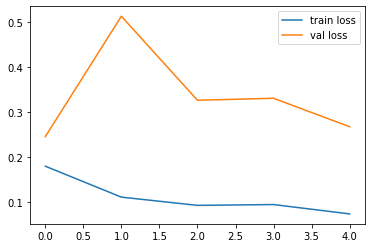

In [24]:
# ploting the loss function 
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [26]:
import tensorflow as tf
from keras.models import load_model
model.save('model_vgg19.h5')

In [27]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('model_vgg19.h5')

In [33]:
#now predict the images without the disease
#after getting the image we have to convert it into the array after that we have to expand the dimension so that we can be able to use all the images
img = image.load_img('/content/drive/My Drive/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

# from the above i have used the normal image from the test data to check whether it is affected with pneumonia or not by predicting we get to now that array 0 is the not affected part and array 1 is affected part.

In [34]:
classes

array([[1.0000000e+00, 1.1053389e-28]], dtype=float32)

In [35]:
#now predict the images with the disease
img = image.load_img('/content/drive/My Drive/val/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes1 = model.predict(img_data)

In [36]:
classes1

array([[0., 1.]], dtype=float32)

#here we get to know that the pperson is affected as we got zero